In [1]:
tup = (0,1,2,3,4,5)
print(tup[:-1])

(0, 1, 2, 3, 4)


In [2]:
print(tup[-4:])

(2, 3, 4, 5)


In [1]:
import torch
import torchvision

In [6]:
data = torchvision.datasets.FashionMNIST(root="",train = True,download= False)

In [7]:
from torch import nn , optim
from torch.autograd import Variable
from torch.nn import functional as F

In [14]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 

training_data = datasets.FashionMNIST(
    root="",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="",
    train=False,
    download=False,
    transform=ToTensor()
)

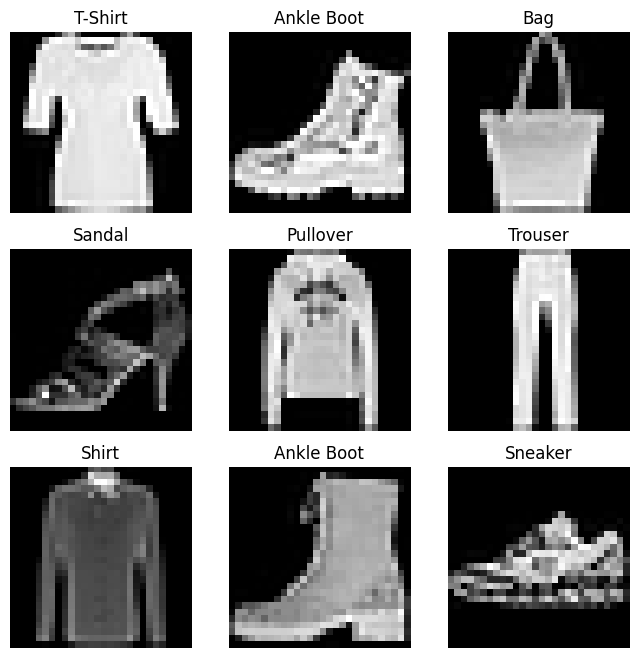

In [19]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


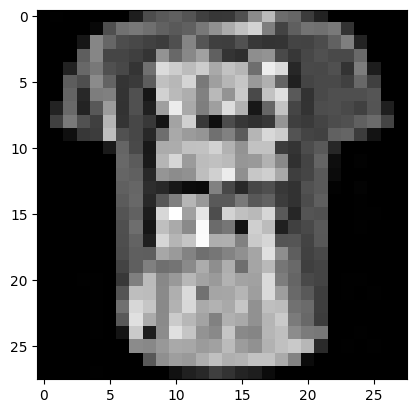

Label: 0


In [17]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [35]:
BATCH_SIZE = 64


In [24]:
class VAE(nn.Module):

    def __init__(self): 
        super(VAE, self).__init__() 
    
    # ENCODER 
        self.fc1 = nn.Linear(784, 400) 
        self.relu = nn.ReLU() 
        self.fc21 = nn.Linear(400, 20) # mu layer 
        self.fc22 = nn.Linear(400, 20) # logvariance layer 
        # DECODER 
        self.fc3 = nn.Linear(20, 400) 
        self.fc4 = nn.Linear(400, 784) 
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> tuple[Variable, Variable]: 
        h1 = self.relu(self.fc1(x)) 
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z: Variable) -> Variable: 
        h3 = self.relu(self.fc3(z)) 
        return self.sigmoid(self.fc4(h3)) 

    def forward(self, x: Variable) -> tuple[Variable, Variable, Variable]:    
        mu, logvar = self.encode(x.view(-1, 784)) # got mu and variance
        z = self.reparameterize(mu, logvar) 
        return self.decode(z), mu, logvar
    
    def reparameterize(self, mu: Variable, logvar: Variable)->Variable:
        #mu : mean matrix 
        #logvar : variance matrix 
        if self.training: 
            std = logvar.mul(0.5).exp_() # type: Variable 
            eps = Variable(std.data.new(std.size()).normal_()) 
            return eps.mul(std).add_(mu) 
        else :
            return mu
    

In [25]:
def loss_function(recon_x, x, mu, logvar) -> Variable: 
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784)) 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 784
    return BCE + KLD

In [26]:
model = VAE()

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
EPOCHS = 40

In [37]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)  # Move data to the device (e.g., CPU or GPU)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Training Error: {train_loss / len(train_dataloader)}")

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_dataloader):
            data = data.to(device)  # Move data to the device (e.g., CPU or GPU)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    print(f"Epoch {epoch}, Testing Error: {test_loss / len(test_dataloader)}")

# Assuming you have defined the 'device' variable to specify whether to use CPU or GPU
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)  # Move the model to the device

for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)


Epoch 1, Training Error: 0.30564041699427785
Epoch 1, Testing Error: 0.30207212981145093
Epoch 2, Training Error: 0.3055328565048002
Epoch 2, Testing Error: 0.3015624902620437
Epoch 3, Training Error: 0.3054207336229048
Epoch 3, Testing Error: 0.3017213612225405
Epoch 4, Training Error: 0.3053071320946537
Epoch 4, Testing Error: 0.3022256104429816
Epoch 5, Training Error: 0.3052422293404272
Epoch 5, Testing Error: 0.3019766217204416
Epoch 6, Training Error: 0.3051511372076169
Epoch 6, Testing Error: 0.3016079569318492
Epoch 7, Training Error: 0.30512852852405514
Epoch 7, Testing Error: 0.30175826333131
Epoch 8, Training Error: 0.3050971000687654
Epoch 8, Testing Error: 0.3016825151291622
Epoch 9, Training Error: 0.30500479662087937
Epoch 9, Testing Error: 0.3019581981904947
Epoch 10, Training Error: 0.30489234054393605
Epoch 10, Testing Error: 0.3020114553202489
Epoch 11, Training Error: 0.30491253911559263
Epoch 11, Testing Error: 0.3014789620402512
Epoch 12, Training Error: 0.3048448

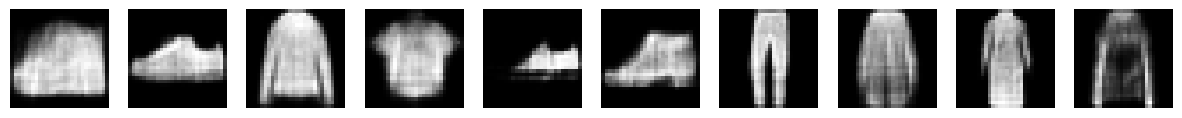

In [34]:
## for 20 epochs 

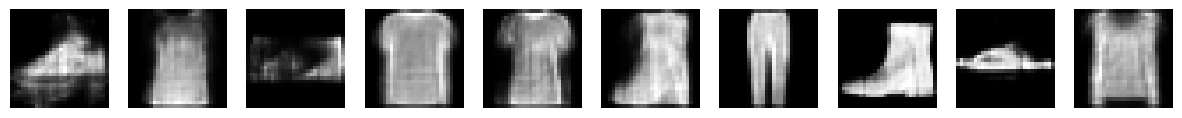

In [38]:
## for 40 epochs 

In [ ]:
def generate_images(model, num_images=10, latent_dim=20):
    model.eval()

    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)  # Sample random latent vectors
        generated_images = model.decode(z)  # Decode the latent vectors

    # Reshape the generated images to their original size (Fashion MNIST images are 28x28)
    generated_images = generated_images.view(-1, 28, 28)

    # Convert the tensor to a NumPy array and unnormalize the pixel values
    generated_images = generated_images.cpu().numpy() * 255.0

    # Display the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i], cmap='gray')
        axs[i].axis('off')
    plt.show()

generate_images(model)

Experiments :

1. Learning Rate: The learning rate (lr) used for the optimizer might be too large or too small. A high learning rate can lead to overshooting the optimal weights, causing instability, while a small learning rate may result in slow convergence. Adjusting the learning rate could help in achieving a smoother decrease in the error over epochs.

2. Model Complexity: The model architecture, in this case, the VAE, may not have enough capacity to capture the underlying patterns in the data. Increasing the model's complexity by adding more layers or units might help improve the performance.

3. Training Data Size: The size and diversity of the training data can also impact the training process. If the dataset is too small or unrepresentative, the model may struggle to generalize well to unseen data.

4. Overfitting: It's possible that the model is overfitting to the training data, which means it is memorizing the training samples but not generalizing well to unseen data. Regularization techniques such as dropout or weight decay can help prevent overfitting.

5. Loss Function: The choice of the loss function can affect the training process. Ensure that the loss function is appropriate for the VAE setup and the task being performed.

6. Normalization: Make sure the input data is properly normalized to have zero mean and unit variance. Incorrect normalization can hinder the convergence of the model.

To address these issues, you can try the following steps:

- Experiment with different learning rates, and consider using learning rate schedules to adjust the learning rate over time.
- Review the model architecture and consider increasing its complexity if needed.
- Check the dataset to ensure it is diverse and representative of the problem you are trying to solve.
- Implement regularization techniques to prevent overfitting.
- Double-check the loss function and normalization methods.

It's essential to monitor the training and testing errors over more epochs and observe if there is a clear pattern or improvement in the performance. Sometimes, training a model may require more epochs to see significant changes in error. Also, consider plotting the training and testing errors over epochs to visualize their trends better.

In [ ]:
# normalizing 

# Define the mean and standard deviation for Fashion MNIST dataset
mean = (0.5,)
std = (0.5,)

# Define the transforms with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
